In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Model
from keras.layers  import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.preprocessing.image import ImageDataGenerator

/home/prateek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/prateek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")

In [3]:
def load_pickle(data_dir):
    file = pickle.load(open(data_dir, 'rb'))
    print(file.keys())
    images, bbox, labels = file['images'], file['bbox'], file['labels']
    return images, bbox, labels

In [4]:
images, bbox, labels = load_pickle(data_dir)

dict_keys(['images', 'bbox', 'labels'])


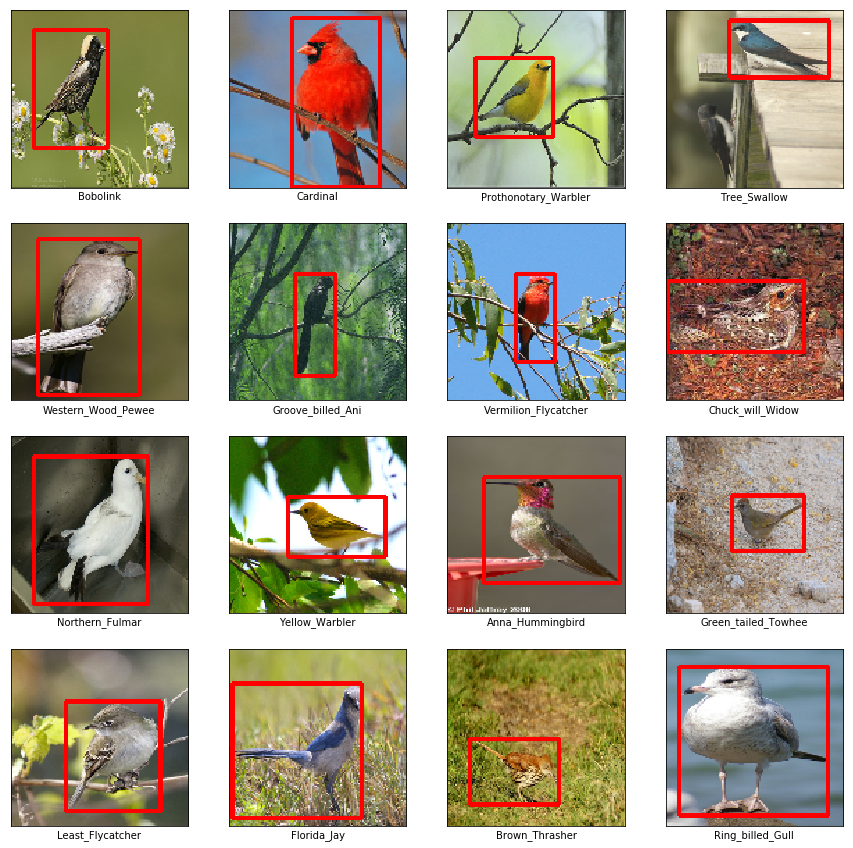

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    idx = np.random.choice(len(images))
    x,y,w,h = bbox[idx]
    img = images[idx]
    cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(labels[idx])

In [6]:
input_shape = images.shape[1:]
num_classes = 200

In [14]:
def create_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(filters=64, kernel_size=(5,5), activation='relu')(input_layer)
    x = Conv2D(filters=64, kernel_size=(5,5), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
    x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=128, activation='relu')(x)

    output_layer_1 = Dense(num_classes, activation='softmax')(x)
    output_layer_2 = Dense(4)(x)

    model = Model(inputs=input_layer, outputs=[output_layer_1, output_layer_2])
    
    model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mean_squared_error'], metrics=['accuracy'])
    
    print(model.summary())

    return model

In [15]:
model = create_model(input_shape, num_classes)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 124, 124, 64) 4864        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 120, 120, 64) 102464      conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 60, 60, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (

In [16]:
# bboxtrain.shape
# ytrain.shape

In [17]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = keras.utils.to_categorical(labels_encoded, num_classes=num_classes)

In [18]:
xtrain, xtest, ytrain, ytest, bboxtrain, bboxtest = train_test_split(images, labels_encoded, bbox, test_size=0.2)

In [21]:
x = np.array([1,2,3,4])
idx = [1,3]
x[idx]

array([2, 4])

In [23]:
def data_generator(x, y1, y2, batch_size):
    while True:
        idx = np.random.choice(np.arange(0, len(x), 1), size=batch_size)
        images = x[idx]
        labels = y1[idx]
        bbox = y2[idx]
        yield(images, [labels, bbox])
generator = data_generator(xtrain, ytrain, bboxtrain, 32)

In [24]:
batch_size = 32
epochs = 10
model.fit_generator(generator, steps_per_epoch=len(xtrain)//batch_size, epochs=epochs)

Epoch 1/10
294/294 [==============================] - 37s 126ms/step - loss: 640.6664 - dense_9_loss: 15.4076 - dense_10_loss: 625.2588 - dense_9_acc: 0.0060 - dense_10_acc: 0.4942
Epoch 2/10
294/294 [==============================] - 35s 120ms/step - loss: 451.3761 - dense_9_loss: 15.0985 - dense_10_loss: 436.2776 - dense_9_acc: 0.0077 - dense_10_acc: 0.5750
Epoch 3/10
294/294 [==============================] - 35s 121ms/step - loss: 381.0888 - dense_9_loss: 14.9941 - dense_10_loss: 366.0948 - dense_9_acc: 0.0064 - dense_10_acc: 0.6463
Epoch 4/10
294/294 [==============================] - 36s 121ms/step - loss: 340.0855 - dense_9_loss: 14.7105 - dense_10_loss: 325.3751 - dense_9_acc: 0.0072 - dense_10_acc: 0.6778
Epoch 5/10
294/294 [==============================] - 35s 120ms/step - loss: 302.1418 - dense_9_loss: 14.6834 - dense_10_loss: 287.4584 - dense_9_acc: 0.0090 - dense_10_acc: 0.6884
Epoch 6/10
294/294 [==============================] - 35s 119ms/step - loss: 267.7881 - dense_9

24 156


(array([[38.066013, 39.55543 , 56.533043, 61.546783]], dtype=float32),
 array([61, 24, 49, 79]))

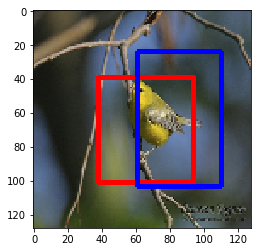

In [39]:
i = 265
pred = model.predict(xtest[i].reshape(1,128,128,3))
pred_label = pred[0]
pred_box = pred[1]
true_label = ytest[0]
true_box = bboxtest[0]

img = xtest[i]
cv2.rectangle(img, (int(pred_box[0][0]), int(pred_box[0][1])), (int(pred_box[0][0]+pred_box[0][2]), int(pred_box[0][1]+pred_box[0][3])), (255,0,0), 2)
cv2.rectangle(img, (true_box[0], true_box[1]), (true_box[0]+true_box[2], true_box[1]+true_box[3]), (0,0,255), 2)
plt.imshow(img)

print(np.argmax(pred_label), np.argmax(true_label))
pred_box, true_box